# Part 1 - estimation

In [124]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

In [125]:
df = pd.read_csv("CVD_cleaned.csv")
print("average weight of smokers and non-smokers:")
print(df.groupby('Smoking_History')['Weight_(kg)'].mean())

average weight of smokers and non-smokers:
Smoking_History
No     82.665153
Yes    84.695707
Name: Weight_(kg), dtype: float64


In [126]:
def calc_CI(avg_non_smokers_,avg_smokers_,se_non_smokers_,se_smokers_):
    # calculating the confidence intervals
    CI_non_smokers = [avg_non_smokers_ - 2*se_non_smokers_, avg_non_smokers_+2*se_non_smokers_]
    CI_smokers = [avg_smokers_-2*se_smokers_, avg_smokers_+2*se_smokers_]
    return {'CI_smokers': CI_smokers, 'CI_non_smokers':CI_non_smokers}

In [127]:
def part_1():
    #filtering
    smokers_df = df[df["Smoking_History"] == 'Yes']['Weight_(kg)']
    non_smokers_df = df[df["Smoking_History"] == 'No']['Weight_(kg)']
    # getting n
    n_non_smokers = len(non_smokers_df)
    n_smokers = len(smokers_df)
    # using biased estimator for the variance
    non_smokers_sample_variance =non_smokers_df.var(ddof=0)
    smokers_sample_variance =smokers_df.var(ddof=0)
    se_non_smokers = ((1/n_non_smokers)*non_smokers_sample_variance)**0.5
    se_smokers = ((1/n_smokers)*smokers_sample_variance)**0.5
    # getting the average per group
    avg_non_smokers = non_smokers_df.mean()
    avg_smokers = smokers_df.mean()
    interval = calc_CI(avg_non_smokers,avg_smokers,se_non_smokers,se_smokers)
    print(f"confidence intervals for smokers:{interval['CI_smokers']}")
    print(f"confidence intervals for non smokers:{interval['CI_non_smokers']}\n")

In [128]:
part_1()

confidence intervals for smokers:[84.57251864131194, 84.81889517426583]
confidence intervals for non smokers:[82.56503785201662, 82.76526821027389]


we know that the MLE of the mean is the sample mean which is asymptotically normal, hence the assumption is valid.
the confidence intervals we got are not overlapping, meaning we can say with 95 percent certainty that there is a
difference between the mean weight of smokers and non-smokers.

# Part 2 - Hypothesis Tests

## Part 2a - The Hypothesis:

### Null Hypothesis (H0):
##### There is no difference between the weight of smokers and nonsmokers.<br/>

### Alternative Hypothesis (H1):
##### There is a difference between the weight of smokers and nonsmokers.

## Part 2b - The Assumptions:

### We need to check if the following assumptions are being met in order to preform an independent T-test:

1. The measurement scale used for such hypothesis testing follows a set of continuous or ordinal patterns. -> we checked it in the previous assigment.
2. The tests are completely based on random sampling. -> we were given a real data which was collected randomly.
3. When the data is plotted with respect to the T-test distribution, it should follow a normal distribution. -> lets check it.
4. The variance should be such that the standard deviations of the samples are almost equal. -> lets check it.

### Let's see if Assumption #3 is being met:

In [129]:
smokers_df = df[df["Smoking_History"] == 'Yes']['Weight_(kg)']
non_smokers_df = df[df["Smoking_History"] == 'No']['Weight_(kg)']

In [130]:
def plot_histogram(data, bins=10, title=None, xlabel=None, ylabel=None):
    """
    Plot a histogram of a specific column data.
    
    Parameters:
    - data (DataFrame or Series): The input data to be plotted.
    - bins (int): Number of bins for the histogram (default is 10).
    - title (str): Title for the plot (default is None).
    - xlabel (str): Label for the x-axis (default is None).
    - ylabel (str): Label for the y-axis (default is None).
    """
    if isinstance(data, pd.Series):
        data = data.to_frame()
    elif not isinstance(data, pd.DataFrame) or data.shape[1] != 1:
        raise ValueError("Input data must be a single-column DataFrame or a Series.")
    
    column_name = data.columns[0]
    
    plt.figure(figsize=(6, 4))
    plt.hist(data[column_name], bins=bins, edgecolor='black')
    
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    
    plt.grid(True)
    plt.show()


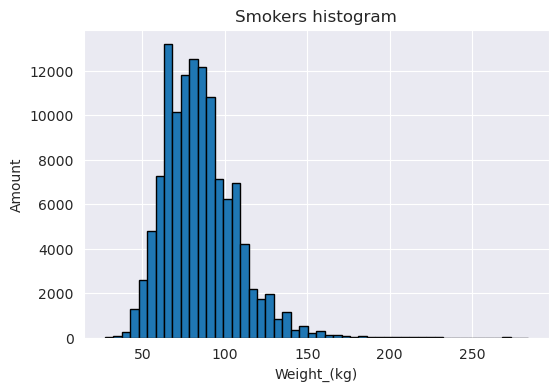

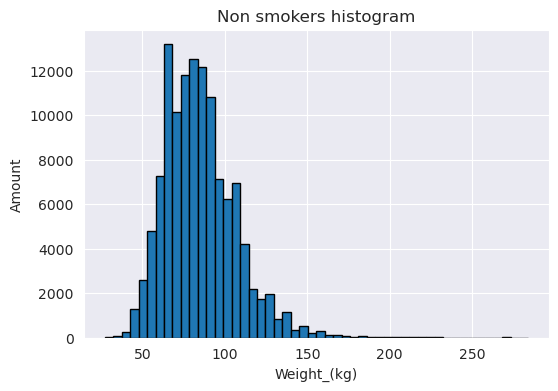

In [131]:
plot_histogram(smokers_df,50,"Smokers histogram",'Weight_(kg)','Amount')
plot_histogram(smokers_df,50,"Non smokers histogram",'Weight_(kg)','Amount')

### We can see from the plots that the data for both groups looks like they come from a normal distribution.

### Let's see if Assumption #4 is being met:

let's check if the variance of the 2 groups are almost equal using a F test:

$\sigma_1$ - sd of the non-smokers.
$\sigma_2$ - sd of the smokers. 

Null Hypothesis (H0):  $\sigma_1^2 = \sigma_2^2$ 

Alternative Hypothesis (H1): $\sigma_1^2 \neq \sigma_2^2$ 

T.S. :  $\( F = \frac{S_X^2}{S_Y^2} = \frac{1}{n - 1} \sum_{i=1}^{n} \frac{(X_i - \bar{X})^2}{n^2} \, / \, \frac{1}{m - 1} \sum_{i=1}^{m} \frac{(Y_i - \bar{Y})^2}{n^2} \sim F(n-1, m-1) \)$

R.R. :  $\( F > F_{(n-1, m-1), \alpha}\)$




In [132]:
def f_test_variances(data_frame1, data_frame2, alpha=0.05):

    group1 = data_frame1.squeeze()
    group2 = data_frame2.squeeze()
    
    var_group1 = np.var(group1, ddof=1)
    var_group2 = np.var(group2, ddof=1)
    
    f_statistic = var_group1 / var_group2 if var_group1 > var_group2 else var_group2 / var_group1
    critical_value = 1 / stats.f.ppf(1 - alpha / 2, len(group1) - 1, len(group2) - 1)
    
    result = "Reject" if f_statistic > critical_value else "Fail to Reject"
    
    return f_statistic, critical_value, result



In [133]:
f_test_variances(non_smokers_df,smokers_df)

(1.0304232536482145, 0.9897269412399613, 'Reject')

### We can see from the results that the variances are significantly different, hance we can say that assumption number five does not hold for our data.

## Part 2c - T test for same variances (with the assumption that the variances are equal):

In [134]:
def t_test(df1,df2):
    t_statistic, P_value = stats.ttest_ind(df1,df2)
    
    t_test_val = stats.t.ppf(0.975, len(df1) + len(df2) - 2)
    
    print("Equal Variances T-Test Results:")
    print("t-statistic: " +  str(t_statistic))
    print("p-value: " + str(P_value))
    print("Reject null hypothesis: " + str(t_test_val < abs(t_statistic)))

In [135]:
t_test(non_smokers_df,smokers_df)

Equal Variances T-Test Results:
t-statistic: -25.65625921540835
p-value: 5.1727187794774844e-145
Reject null hypothesis: True


## Part 2d - Wald test:

#### $\(H_0: \mu_1 = \mu_2\)$

#### $\(H_0: \mu_1 \neq \mu_2\)$

#### $\(\bar{X}_1\)$ and $\(\bar{X}_2\)$ are the sample means and $\(s_1\)$ and $\(s_2\)$ are the sample standard deviations

#### $\[ W = \frac{(\bar{X}_1 - \bar{X}_2)}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} \]$

####  If the test statistic is greater than the critical value or if the p-value is less than the chosen significance level $(\(\alpha\))$, the null hypothesis is rejected.

In [136]:
def wald_test_two_means(dataframe1, dataframe2, alpha=0.05):
    sample1 = dataframe1.values.flatten()
    sample2 = dataframe2.values.flatten()

    n1 = len(sample1)
    n2 = len(sample2)
    
    mean1 = np.mean(sample1)
    mean2 = np.mean(sample2)
    
    var1 = np.var(sample1)  
    var2 = np.var(sample2)
    
    
    test_statistic = (mean1 - mean2) / (np.sqrt(var1 / n1 + var2 / n2))
    
    
    
    # Calculate p-value using standard normal distribution
    p_value = 2 * stats.norm.cdf(-abs(test_statistic))
    
    print("Test statistic: " + str(test_statistic))
    print("P-value: " + str(p_value))
    print("test quantile: " + str(stats.norm.ppf(0.975)))
    print("Reject null hypothesis: " + str(stats.norm.ppf(0.975) < abs(test_statistic)))

In [137]:
wald_test_two_means(non_smokers_df,smokers_df)

Test statistic: -25.583387350455347
P-value: 2.3353052222178754e-144
test quantile: 1.959963984540054
Reject null hypothesis: True


## Part 2e - Results & P-values:
We can see that in both cases the P-values are very small and that in both tests we are rejecting the null hypothesis. 
that makes sense because we are using 2 different but similar distributions, in the T-test we are using t distribution and in the Wald test we are using Normal distribution.

## Part 2f - Likelihood Ratio Test:

#### $\(H_0: \mu_1 - \mu_2\)$

#### $\(H_0: \mu_1 \neq \mu_2\)$

$ \text{Likelihood Ratio} = 2 \cdot \left( \ln(\mathcal{L}_{\text{alt}}) - \ln(\mathcal{L}_{\text{null}})   \right) $

After developing the likelihood Ratio we get the following formula for the statistic:

 = $ n\log\left(\frac{\hat{\sigma^2}}{S_p ^ 2}\right) + \sum_{i=1}^{n_1} \left(\frac{(x_{1i} - \hat{\mu})^2}{\hat{\sigma}^2} - \frac{(x_{1i} - \hat{\mu_1})^2}{S_p ^ 2}\right) + \sum_{i=1}^{n_2} \left(\frac{(x_{2i} - \hat{\mu})^2}{\hat{\sigma}^2} - \frac{(x_{2i} - \hat{\mu_2})^2}{S_p ^ 2}\right) $ 


In [138]:
def likelihood_ratio_test(df1, df2, alpha=0.05):
    
    # Creating 3 np.arrays
    data1 = df1.values.flatten()
    data2 = df2.values.flatten()
    data_combined = np.concatenate((data1, data2))
    
    # Creating measurements (mean, var, pooled, var, n)
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    mean_combined = np.mean(data_combined)
    var1 = np.var(data1)
    var2 = np.var(data2)
    var_combined = np.var(data_combined)
    n = len(data_combined)
    pooled_variance = ((len(data1) - 1) * var1 + (len(data2) - 1) * var2) / (len(data1) + len(data2) - 2)
    
    # Creating the 3 different parts of the statistic we developed
    n_log_sigma_sp2 = n * np.log(var_combined / pooled_variance) 
    first_sum = np.sum(((data1 - mean_combined)**2 / var_combined) - ((data1 - mean1)**2 / pooled_variance))
    second_sum = np.sum(((data2 - mean_combined)**2 / var_combined) - ((data2 - mean2)**2 / pooled_variance))
    
    # Combining all for the statistic
    statistic = n_log_sigma_sp2 + first_sum + second_sum
    
    # Finding the Chi squared quantile
    chi_value = stats.chi2.ppf(0.95,1)
    
    result = {
        'statistic': {statistic},
        'chi_value': {chi_value},
        'reject_null': {statistic > chi_value}
    }

    return result

In [139]:
likelihood_ratio_test(non_smokers_df,smokers_df)

{'statistic': {657.5252840603022},
 'chi_value': {3.841458820694124},
 'reject_null': {True}}

# part 3 - Different Sample Sizes

## part 3 - a,b,c

In [140]:
def parts_abc(smokers_mean, non_smokers_mean, part_d=False):
    """
    Perform statistical analysis for parts A, B, and C, and optionally D.

    Parameters:
    smokers_mean (float): Expected mean weight for smokers.
    non_smokers_mean (float): Expected mean weight for non-smokers.
    part_d (bool, optional): If True, include Part D analysis. Default is False.

    Returns:
    None

    This function performs statistical analysis for parts A, B, and C of the problem,
    and optionally for Part D if specified. It calculates confidence intervals,
    performs Wald hypothesis tests, and analyzes the percentage of intervals
    containing the expected means.

    Parameters:
    - smokers_mean: Expected mean weight for smokers.
    - non_smokers_mean: Expected mean weight for non-smokers.
    - part_d: Boolean indicating whether to include Part D analysis (optional).

    For each sample size in 'sizes':
    - Generate intervals and p-values for smokers and non-smokers.
    - Calculate the percentage of intervals containing the expected means.

    If 'part_d' is True:
    - Plot the intervals' widths and p-values.
    - Print the percentage of intervals containing the expected means for both groups.

    Example usage:
    parts_abc(70, 65, part_d=True)
    """

    np.random.seed(42)
    sizes = [30, 50, 100, 500]
    intervals = {size: {'smokers': [], 'non_smokers': []} for size in sizes}
    p_vals = {size: [] for size in sizes}
    within_interval = {'smokers': 0, 'non_smokers': 0}
    rounds = 100 if part_d else 1

    for size in sizes:
        for _ in range(rounds):
            sample = df.sample(n=size)
            # Filtering
            smokers_df = sample[sample["Smoking_History"] == 'Yes']['Weight_(kg)']
            non_smokers_df = sample[sample["Smoking_History"] == 'No']['Weight_(kg)']

            # Getting sample sizes
            n_non_smokers = len(non_smokers_df)
            n_smokers = len(smokers_df)

            # Using biased estimator for the variance
            non_smokers_sample_variance = non_smokers_df.var(ddof=0)
            smokers_sample_variance = smokers_df.var(ddof=0)
            se_non_smokers = ((1/n_non_smokers) * non_smokers_sample_variance)**0.5
            se_smokers = ((1/n_smokers) * smokers_sample_variance)**0.5

            # Getting the average per group
            avg_non_smokers = non_smokers_df.mean()
            avg_smokers = smokers_df.mean()

            # Calculate confidence intervals
            interval = calc_CI(avg_non_smokers, avg_smokers, se_non_smokers, se_smokers)

            # Calculate Wald standard error and p-value
            wald_se_hat = (smokers_sample_variance/n_smokers + non_smokers_sample_variance/n_non_smokers)**0.5
            if part_d:
                P_val = wald_test(avg_smokers - avg_non_smokers, 0, wald_se_hat,verbose=False)
            else:
                P_val = wald_test(avg_smokers - avg_non_smokers, 0, wald_se_hat)
                print(f"Intervals for sample size: {size}")
                print(f"Confidence intervals for smokers: {interval['CI_smokers']}")
                print(f"Confidence intervals for non-smokers: {interval['CI_non_smokers']}\n")

            # Update intervals and p-values (Part D)
            if part_d:
                intervals[size]['smokers'].append(interval['CI_smokers'][1] - interval['CI_smokers'][0])
                intervals[size]['non_smokers'].append(interval['CI_non_smokers'][1] - interval['CI_non_smokers'][0])
                p_vals[size].append(P_val)

            # Check if expected means are within intervals
            if number_in_interval(smokers_mean, interval['CI_smokers']):
                within_interval['smokers'] += 1
            if number_in_interval(non_smokers_mean, interval['CI_non_smokers']):
                within_interval['non_smokers'] += 1

    # Perform Part D analysis if specified
    if part_d:
        plot_intervals(intervals, sizes)
        plot_P_val(p_vals, sizes)
        print(f"Percentage of intervals that the smokers average was within the interval: {within_interval['smokers'] * 0.25}%")
        print(f"Percentage of intervals that the non-smokers average was within the interval: {within_interval['non_smokers'] * 0.25}%")

In [141]:
def wald_test(theta_hat,theta_0,se_hat,verbose = True):
    """
    Perform a Wald hypothesis test.

    Parameters:
    theta_hat (float): Estimated parameter value.
    theta_0 (float): Null hypothesis value to be tested.
    se_hat (float): Standard error estimate of the parameter.
    verbose (bool, optional): If True, print test details. Default is True.

    Returns:
    float: Two-sided p-value for the Wald test.
    """
    T = theta_hat - theta_0 / se_hat
    W_test_quantile = stats.norm.ppf(0.975)
    P_val = 2*stats.norm.cdf(-abs(T))
    if verbose:
        print("Wald Test with alpha = 0.05")
        print(f"H0: theta = {theta_0}")
        print(f"H1: theta != {theta_0}")
        print(f"Test statistic: {T:.5f}")
        print(f"{abs(T)} > ? {W_test_quantile}")
        print(f"Rejected: {abs(T)>W_test_quantile}")
        print(f"P value: {P_val:.5f}\n\n")
    return P_val

In [142]:
def plot_intervals(intervals,sizes):
    """
    Plot histograms of interval widths for smokers and non-smokers.

    Parameters:
    intervals (dict): A dictionary containing interval widths for each sample size.
                      Expected structure: {size: {'smokers': [...], 'non_smokers': [...]}, ...}
    sizes (list): List of sample sizes.

    Returns:
    None

    This function creates a grid of histograms to visualize the distribution of interval
    widths for smokers and non-smokers at different sample sizes.

    Parameters:
    - intervals: A dictionary containing interval widths for each sample size.
    - sizes: List of sample sizes.

    The function generates histograms for both smokers and non-smokers, displaying the
    distribution of interval widths for each sample size. Each histogram represents a
    different sample size and is displayed side by side.

    Example usage:
    plot_intervals(intervals, [30, 50, 100, 500])
    """
    # Create subplots for each size with two histograms side by side
    fig, axes = plt.subplots(len(sizes), 2, figsize=(12, 8))

    # Loop through sizes and create subplots
    for i, size in enumerate(sizes):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        # Plot histogram for smokers
        ax1.hist(intervals[size]['smokers'], bins=20, alpha=0.5, color='royalblue', label='Smokers')
        ax1.set_title(f'Size: {size}')
        ax1.set_xlabel('Interval Size')
        ax1.set_ylabel('Frequency')
        ax1.legend()

        # Plot histogram for non-smokers
        ax2.hist(intervals[size]['non_smokers'], bins=20, alpha=0.5, color='orange', label='Non-Smokers')
        ax2.set_title(f'Size: {size}')
        ax2.set_xlabel('Interval Size')
        ax2.set_ylabel('Frequency')
        ax2.legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


In [143]:
def number_in_interval(number, interval):
    """
    Check if a number falls within a specified interval.

    Parameters:
    number (float): The number to be checked.
    interval (tuple): A tuple containing the lower and upper bounds of the interval.

    Returns:
    bool: True if the number is within the interval, False otherwise.
    """
    interval_start, interval_end = interval
    return interval_start <= number <= interval_end

In [144]:
def plot_P_val(p_vals,sizes):
    """
    Plot histograms of p-values distribution for different sample sizes.

    Parameters:
    p_vals (dict): A dictionary containing p-values for each sample size.
                   Expected structure: {size: [...], ...}
    sizes (list): List of sample sizes.

    Returns:
    None

    This function creates a grid of histograms to visualize the distribution of p-values
    for different sample sizes.

    Parameters:
    - p_vals: A dictionary containing p-values for each sample size.
    - sizes: List of sample sizes.

    The function generates histograms representing the distribution of p-values for each
    sample size. Each histogram represents a different sample size and is displayed side by side.

    Example usage:
    plot_P_val(p_vals, [30, 50, 100, 500])
    """
    # Calculate grid dimensions
    num_rows = 2
    num_cols = 2

    # Create a grid of plots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    # Flatten the axes array to iterate over all subplots
    axes = axes.flatten()

    # Loop through sizes and create plots
    for i, size in enumerate(sizes):
        ax = axes[i]
        ax.hist(p_vals[size], bins=20, alpha=0.7, color='green')
        ax.set_title(f'P-Values Distribution (Size: {size})')
        ax.set_xlabel('P-Value')
        ax.set_ylabel('Frequency')
        ax.grid(True)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()


In [145]:
non_smokers_avg = df[df["Smoking_History"] == 'No']['Weight_(kg)'].mean()
smokers_avg = df[df["Smoking_History"] == 'Yes']['Weight_(kg)'].mean()
parts_abc(smokers_avg,non_smokers_avg)

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: -0.18036
0.18036199095023164 > ? 1.959963984540054
Rejected: False
P value: 0.85687


Intervals for sample size: 30
Confidence intervals for smokers: [68.60700100976203, 90.42992206716104]
Confidence intervals for non-smokers: [68.29149438750295, 91.10615267132059]

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: 2.94143
2.941428571428574 > ? 1.959963984540054
Rejected: True
P value: 0.00327


Intervals for sample size: 50
Confidence intervals for smokers: [78.89477517540219, 91.57522482459781]
Confidence intervals for non-smokers: [73.8658326552762, 90.72131020186666]

Wald Test with alpha = 0.05
H0: theta = 0
H1: theta != 0
Test statistic: -0.06592
0.0659166666666664 > ? 1.959963984540054
Rejected: False
P value: 0.94744


Intervals for sample size: 100
Confidence intervals for smokers: [75.24090799579916, 88.28259200420085]
Confidence intervals for non-smokers: [76.22315686816677, 87.43

we can notice that the confidence intervals are much larger with smaller sample sizes, but we seem to begin
converging as the sample sizes increase

## part 3 - d

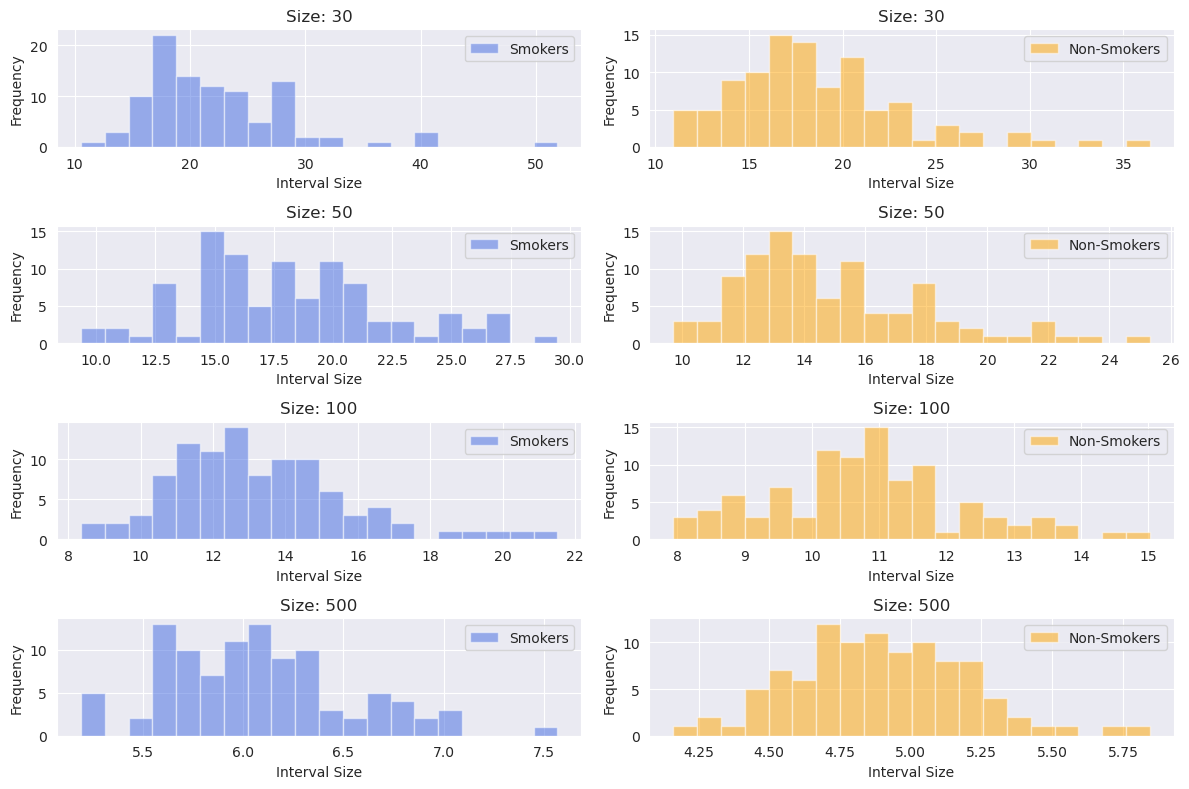

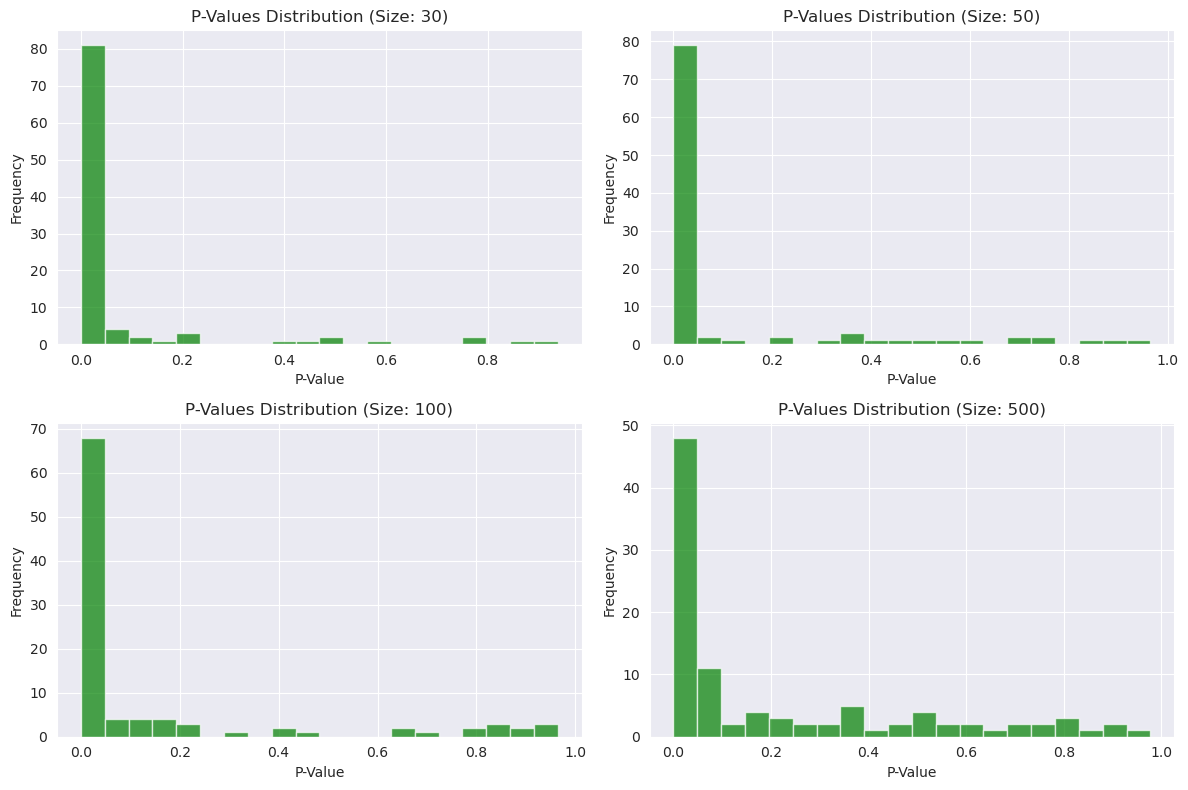

Percentage of intervals that the smokers average was within the interval: 90.5%
Percentage of intervals that the non-smokers average was within the interval: 94.5%


In [146]:
parts_abc(smokers_avg,non_smokers_avg,part_d=True)

### Conclusions

we can notice that the confidence intervals are much larger with smaller sample sizes, and in most cases, we can
reject the null hypothesis with at least 95% certainty